# Segmenter

## Dataset

First, we'll install the required dependencies and download the SPIDER dataset from HuggingFace:

In [14]:
!pip install scikit-image torchinfo


You should consider upgrading via the '/Users/haily/.pyenv/versions/3.10.4/bin/python3.10 -m pip install --upgrade pip' command.


We'll check the structure of the data to confirm that we have a train, validation, and test split:

In [16]:
from imutils import paths
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import os
import pandas as pd
from torchvision.datasets.flickr import glob
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

img_dir = "./datasets/Shenzhen/img"
mask_dir = "./datasets/Shenzhen/mask"
image_paths = [path.split('/')[-1] for path in sorted(list(paths.list_images(img_dir)))]
fit_imgs, test_imgs = train_test_split(image_paths, test_size=0.25, random_state=42)
train_imgs, val_imgs = train_test_split(fit_imgs, test_size=0.25, random_state=42)

print(train_imgs)

class SegImageDataset(Dataset):
    def __init__(self, imgs, img_dir, mask_dir):
        self.imgs = imgs
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = read_image(f'{self.img_dir}/{self.imgs[idx]}').float() / 255.0
        mask = torch.argmax(read_image(f'{self.mask_dir}/{self.imgs[idx]}', ImageReadMode.GRAY_ALPHA), dim=0).long()

        return image, mask
    
train = SegImageDataset(train_imgs, img_dir, mask_dir)
val = SegImageDataset(val_imgs, img_dir, mask_dir)
test = SegImageDataset(test_imgs, img_dir, mask_dir)
train_dataloader = DataLoader(train, batch_size=4)
test_dataloader = DataLoader(test, batch_size=4)
val_dataloader = DataLoader(val, batch_size=4)

['CHNCXR_0507_1.png', 'CHNCXR_0337_1.png', 'CHNCXR_0121_0.png', 'CHNCXR_0608_1.png', 'CHNCXR_0511_1.png', 'CHNCXR_0326_0.png', 'CHNCXR_0325_0.png', 'CHNCXR_0609_1.png', 'CHNCXR_0300_0.png', 'CHNCXR_0446_1.png', 'CHNCXR_0009_0.png', 'CHNCXR_0546_1.png', 'CHNCXR_0174_0.png', 'CHNCXR_0474_1.png', 'CHNCXR_0236_0.png', 'CHNCXR_0271_0.png', 'CHNCXR_0066_0.png', 'CHNCXR_0626_1.png', 'CHNCXR_0244_0.png', 'CHNCXR_0573_1.png', 'CHNCXR_0368_1.png', 'CHNCXR_0640_1.png', 'CHNCXR_0571_1.png', 'CHNCXR_0285_0.png', 'CHNCXR_0057_0.png', 'CHNCXR_0263_0.png', 'CHNCXR_0526_1.png', 'CHNCXR_0127_0.png', 'CHNCXR_0067_0.png', 'CHNCXR_0435_1.png', 'CHNCXR_0278_0.png', 'CHNCXR_0538_1.png', 'CHNCXR_0147_0.png', 'CHNCXR_0108_0.png', 'CHNCXR_0273_0.png', 'CHNCXR_0402_1.png', 'CHNCXR_0519_1.png', 'CHNCXR_0389_1.png', 'CHNCXR_0105_0.png', 'CHNCXR_0468_1.png', 'CHNCXR_0104_0.png', 'CHNCXR_0045_0.png', 'CHNCXR_0600_1.png', 'CHNCXR_0425_1.png', 'CHNCXR_0637_1.png', 'CHNCXR_0281_0.png', 'CHNCXR_0533_1.png', 'CHNCXR_0476

## Defining the Model Architecture



Next, let's specify the model architecture. This example uses [PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html), but you could build something similar with [Keras/TensorFlow](https://keras.io/getting_started/).

We'll start by importing packages and checking if we have a GPU available for model training:

In [20]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import _load_weights
from einops import rearrange
from torchinfo import summary
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

mps


## Model

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def resize_pos_embed(posemb, grid_old_shape, grid_new_shape, num_extra_tokens):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    posemb_tok, posemb_grid = (
        posemb[:, :num_extra_tokens],
        posemb[0, num_extra_tokens:],
    )
    if grid_old_shape is None:
        gs_old_h = int(math.sqrt(len(posemb_grid)))
        gs_old_w = gs_old_h
    else:
        gs_old_h, gs_old_w = grid_old_shape

    gs_h, gs_w = grid_new_shape
    posemb_grid = posemb_grid.reshape(1, gs_old_h, gs_old_w, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_h, gs_w), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb

def padding(im, patch_size, fill_value=0):
    # make the image sizes divisible by patch_size
    H, W = im.size(2), im.size(3)
    pad_h, pad_w = 0, 0
    if H % patch_size > 0:
        pad_h = patch_size - (H % patch_size)
    if W % patch_size > 0:
        pad_w = patch_size - (W % patch_size)
    im_padded = im
    if pad_h > 0 or pad_w > 0:
        im_padded = F.pad(im, (0, pad_w, 0, pad_h), value=fill_value)
    return im_padded


def unpadding(y, target_size):
    H, W = target_size
    H_pad, W_pad = y.size(2), y.size(3)
    # crop predictions on extra pixels coming from padding
    extra_h = H_pad - H
    extra_w = W_pad - W
    if extra_h > 0:
        y = y[:, :, :-extra_h]
    if extra_w > 0:
        y = y[:, :, :, :-extra_w]
    return y
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = dim
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads, dropout):
        super().__init__()
        self.heads = heads
        head_dim = dim // heads
        self.scale = head_dim ** -0.5
        self.attn = None

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, C // self.heads)
            .permute(2, 0, 3, 1, 4)
        )
        
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
       

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
    
        return x, attn

class Block(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout, drop_path):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dropout)
        self.mlp = FeedForward(dim, mlp_dim, dropout)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x, mask=None, return_attention=False):
        x = self.norm1(x)

        y, attn = self.attn(x, mask)
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, channels):
        super().__init__()

        self.image_size = image_size
        if image_size[0] % patch_size != 0 or image_size[1] % patch_size != 0:
            raise ValueError("image dimensions must be divisible by the patch size")
        self.grid_size = image_size[0] // patch_size, image_size[1] // patch_size
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, n_layers, d_model, 
                 d_ff, n_heads, n_cls,
                 dropout=0.1, drop_path_rate=0.0, distilled=False, channels=3,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, d_model, channels)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.n_cls = n_cls

        # cls and pos tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.distilled = distilled
        if self.distilled:
            self.dist_token = nn.Parameter(torch.zeros(1, 1, d_model))
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 2, d_model)
            )
            self.head_dist = nn.Linear(d_model, n_cls)
        else:
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 1, d_model)
            )

        # transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        # output head
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_cls)

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        if self.distilled:
            trunc_normal_(self.dist_token, std=0.02)
        self.pre_logits = nn.Identity()

        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token", "dist_token"}

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=""):
        _load_weights(self, checkpoint_path, prefix)

    def forward(self, im, return_features=False):
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed
        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if return_features:
            return x

        if self.distilled:
            x, x_dist = x[:, 0], x[:, 1]
            x = self.head(x)
            x_dist = self.head_dist(x_dist)
            x = (x + x_dist) / 2
        else:
            x = x[:, 0]
            x = self.head(x)
        return x

    def get_attention_map(self, im, layer_id):
        if layer_id >= self.n_layers or layer_id < 0:
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed

        for i, blk in enumerate(self.blocks):
            if i < layer_id:
                x = blk(x)
            else:
                return blk(x, return_attention=True)

class DecoderLinear(nn.Module):
    def __init__(self, n_cls, patch_size, d_encoder):
        super().__init__()

        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_encoder, n_cls)
        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size
        x = self.head(x)
        ## h*w = n
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x
    
class Segmenter(nn.Module):
    def __init__(self, encoder, decoder, n_cls):
        super().__init__()
        self.n_cls = n_cls
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder

    @torch.jit.ignore
    def no_weight_decay(self):
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params

    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        im = padding(im, self.patch_size)
        H, W = im.size(2), im.size(3)

        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        masks = self.decoder(x, (H, W))

        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        masks = unpadding(masks, (H_ori, W_ori))

        return masks

## Training the Model

To simplify the segmentation task for this tutorial, we'll use our model to segment only vertebrae vs. non-vertebrae pixels (as opposed to all of the types of anatomical structures that were segmented in the original SPIDER data). We'll use the momentum of 0.99 and batch size of 1 image used in the original paper. We'll also frame our problem as a multi-class classification problem and set our loss function as Cross Entropy (see this [helpful post](https://discuss.pytorch.org/t/understanding-channels-in-binary-segmentation/79966/2) for more details).

In [19]:
# Set parameters from U-Net paper
momentum = 0.99
batch_size = 1

# Set task-specific parameters
in_channels = 3     # grayscale images
n_classes = 2       # vertebrae/non-vertebrae

shenzen_config = {
    'encoder': {
        'image_size': (512, 512),
        'patch_size': 16,
        'd_model': 768,
        'n_heads': 3,
        'd_ff': 768 * 4, # 4 x d_model
        'n_layers': 12,
        'n_cls': 1000,
        'distilled': False,
        'channels': 3,
    },
    'decoder': {
        'drop_path_rate': 0.0,
        'dropout': 0.1,
        'n_layers': 3,
    },
}

# Create model
encoder = VisionTransformer(**shenzen_config['encoder'])
decoder = DecoderLinear(
            patch_size=encoder.patch_size, 
            n_cls=2, 
            d_encoder=encoder.d_model)
model = Segmenter(encoder, decoder, 2)
print(summary(model, (2, 3, 512, 512)))
model.to(device)

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(momentum, 0.999))

# Specify loss function
criterion = nn.CrossEntropyLoss()

Layer (type:depth-idx)                   Output Shape              Param #
Segmenter                                [2, 2, 512, 512]          --
├─VisionTransformer: 1-1                 [2, 1025, 768]            1,556,968
│    └─PatchEmbedding: 2-1               [2, 1024, 768]            --
│    │    └─Conv2d: 3-1                  [2, 768, 32, 32]          590,592
│    └─Dropout: 2-2                      [2, 1025, 768]            --
│    └─ModuleList: 2-3                   --                        --
│    │    └─Block: 3-2                   [2, 1025, 768]            7,087,872
│    │    └─Block: 3-3                   [2, 1025, 768]            7,087,872
│    │    └─Block: 3-4                   [2, 1025, 768]            7,087,872
│    │    └─Block: 3-5                   [2, 1025, 768]            7,087,872
│    │    └─Block: 3-6                   [2, 1025, 768]            7,087,872
│    │    └─Block: 3-7                   [2, 1025, 768]            7,087,872
│    │    └─Block: 3-8         

In [21]:
n_epochs = 40
lowest_loss = None
models_dir = './segmenter_sz'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Folder '{models_dir}' created.")

for epoch in range(n_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    # Training loop
    model.train()
    for batch_idx, (train_image, train_mask) in enumerate(tqdm(train_dataloader)): 
        # Convert input image to (batch_size, channels, height, width)
        train_image = train_image.to(device)

        # Convert mask to (batch_size, height, width)
        train_mask = train_mask.to(device)

        # Forward pass
        output = model(train_image)

        # Backward pass
        optimizer.zero_grad()
        loss = criterion(output, train_mask)
        loss.backward()
        optimizer.step()

        # Record batch loss
        epoch_train_loss += loss.item()

    # Validation loop
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (val_image, val_mask) in enumerate(tqdm(val_dataloader)): 
            # Convert input image to (batch_size, channels, height, width)
            val_image = val_image.to(device)

            # Convert mask to (batch_size, height, width)
            val_mask = val_mask.to(device)

            # Generate prediction
            output = model(val_image)

            # Compute loss
            loss = criterion(output, val_mask)

            # Record batch loss
            epoch_val_loss += loss.item()

    # Print loss
    print(f'Epoch {epoch+1} validation loss: {round(epoch_val_loss, 3)}, train loss: {round(epoch_train_loss, 3)}')

    # Save model if improving
    if (lowest_loss is None) or (epoch_val_loss < lowest_loss):
        lowest_loss = epoch_val_loss
        save_model_path = os.path.join(models_dir, f'sz_segmeter_epoch{epoch+1}.pt')
        torch.save(model.state_dict(), save_model_path)
        print(f'Model saved for epoch {epoch+1}.')


  1%|▏         | 1/80 [00:59<1:18:07, 59.33s/it]


KeyboardInterrupt: 

## Generating New Segmentation Masks for the Test Data

Let's evaluate our model qualitatively by predicting new masks for the held-out test images. First, we'll load the saved model parameters from the model directory:

In [30]:
load_model_path = os.path.join(models_dir, 'UNet_SPIDER_epoch14.pt')
model.load_state_dict(torch.load(load_model_path, map_location=torch.device(device)))

<All keys matched successfully>

We'll create a function called `predict` that takes an element from our SPIDER test dataset and returns the predicted mask, original image, and actual mask:

In [42]:
def predict(model, test_image):
    """Generate prediction for a single test image."""
    model.eval()
    with torch.no_grad():
            test_image = test_image.unsqueeze(0).to(device)
            # Generate prediction
            output = model(test_image)[0]
            prediction = torch.argmax(output, 0)

    return prediction


Note that the output are the probabilities of the corresponding pixels belonging to each class, so we take the argmax over the 1st dimension (the channels dimension) to create a binary {0, 1} prediction. Now we can compare our predicted mask against the actual mask for several test images:

torch.Size([512, 512])


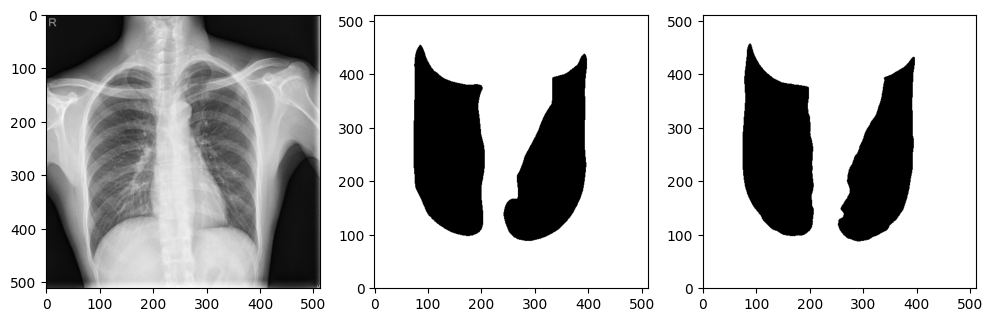

torch.Size([512, 512])


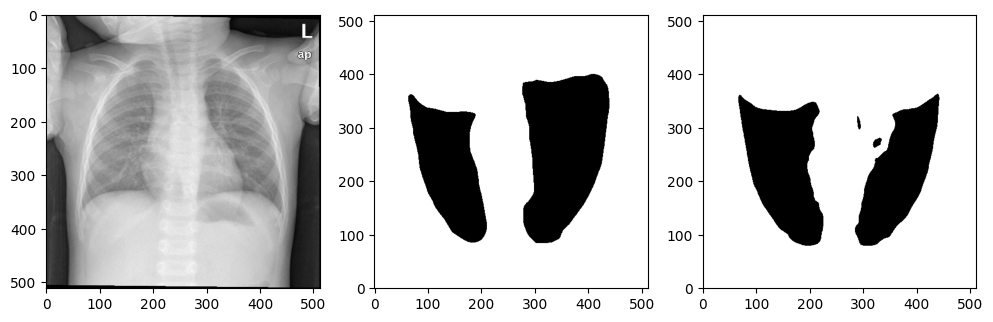

torch.Size([512, 512])


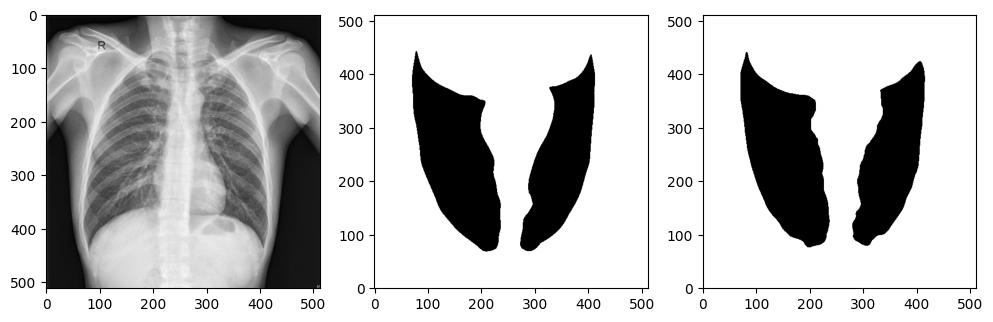

In [46]:
import matplotlib.pyplot as plt

start_idx, end_idx = 22, 25 # Select 3 images to plot

for i in range(start_idx, end_idx): # Select 3 images to plot
    test_image, test_mask = test[i]
    prediction = predict(model, test_image)
    print(prediction.shape)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    ax[0].imshow(test_image.permute(1, 2, 0))
    ax[1].imshow(test_mask, cmap='gray', vmin=0, vmax=1, origin='lower')
    ax[2].imshow(prediction.cpu(), cmap='gray', vmin=0, vmax=1, origin='lower')

    # ax[0].set_title(f'Test Image (Depth: {depth_idx+1})')
    # ax[1].set_title(f'Actual Mask (Depth: {depth_idx+1})')
    # ax[2].set_title(f'Predicted Mask (Depth: {depth_idx+1})')

    plt.show();

Let's also overlay the predicted and actual segmentation masks:



In [ ]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['none', 'chartreuse'], name='custom_categorical_cmap')

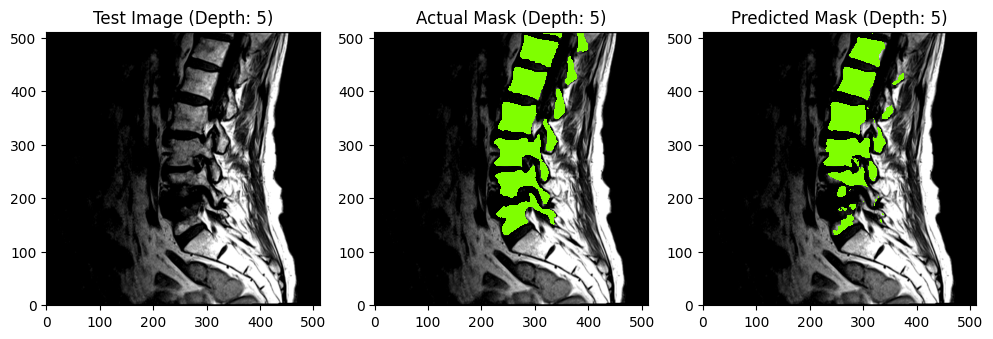

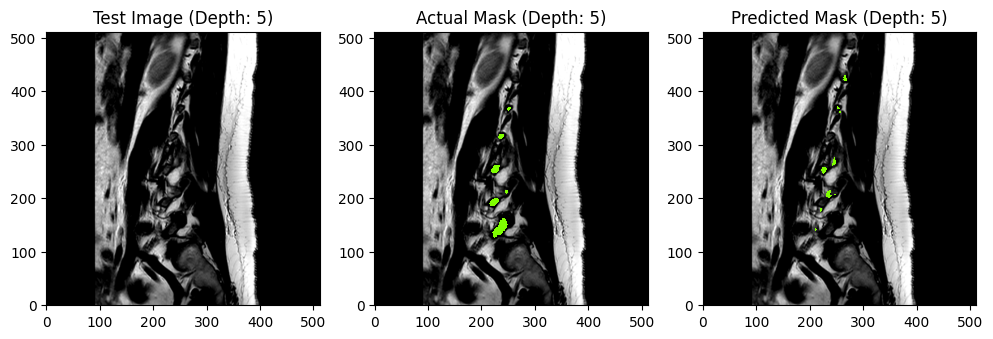

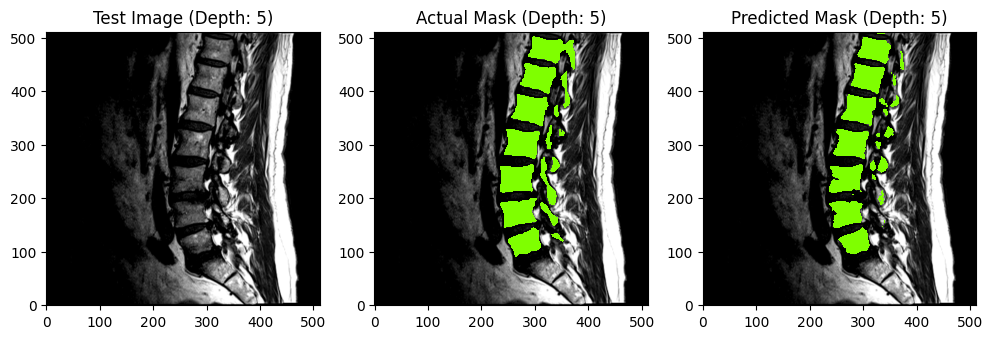

In [ ]:
for i in range(start_idx, end_idx):
    prediction, test_image, test_mask = predict(model, dataset['test'][i], depth_idx)

    fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    for j in range(3):
        ax[j].imshow(test_image.cpu().reshape(512, 512), cmap='gray', origin='lower')
    ax[1].imshow(test_mask.cpu().reshape(512, 512), cmap=cmap, vmin=0, vmax=1, origin='lower')
    ax[2].imshow(prediction.cpu().reshape(512, 512), cmap=cmap, vmin=0, vmax=1, origin='lower')

    ax[0].set_title(f'Test Image (Depth: {depth_idx+1})')
    ax[1].set_title(f'Actual Mask (Depth: {depth_idx+1})')
    ax[2].set_title(f'Predicted Mask (Depth: {depth_idx+1})')

    plt.show();

In future extensions of this tutorial, we'll explore ways to segment 3-dimensional images as well as apply various data augmentation techniques to improve model performance.

### Sources



- *van der Graaf, J.W., van Hooff, M.L., Buckens, C.F.M. et al. (2024) Lumbar spine segmentation in MR images: a dataset and a public benchmark. https://doi.org/10.1038/s41597-024-03090-w*

- *Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. https://doi.org/10.1007/978-3-319-24574-4_28*

- https://github.com/milesial/Pytorch-UNet/tree/master

- https://discuss.pytorch.org/t/understanding-channels-in-binary-segmentation/79966/2